In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
df = pd.read_csv(url)

print(df.head())
print(df.info())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

In [2]:
# ================================
# California Housing Preprocessing
# ================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --------------------------------
# 1. Load Original Dataset
# --------------------------------

url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
df = pd.read_csv(url)

print("Initial shape:", df.shape)
print("\nColumns:")
print(df.columns)
print("\nMissing values:")
print(df.isnull().sum())


# --------------------------------
# 2. Train-Test Split (IMPORTANT)
# --------------------------------
# Avoid data leakage by splitting before preprocessing

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("\nTrain shape:", train_df.shape)
print("Test shape:", test_df.shape)

# --------------------------------
# 3. Separate Features and Target
# --------------------------------

X_train = train_df.drop("median_house_value", axis=1)
y_train = train_df["median_house_value"]

X_test = test_df.drop("median_house_value", axis=1)
y_test = test_df["median_house_value"]

# --------------------------------
# 4. Feature Engineering
# --------------------------------

def add_extra_features(X):
    X = X.copy()
    X["rooms_per_household"] = X["total_rooms"] / X["households"]
    X["bedrooms_per_room"] = X["total_bedrooms"] / X["total_rooms"]
    X["population_per_household"] = X["population"] / X["households"]
    return X

X_train = add_extra_features(X_train)
X_test = add_extra_features(X_test)

Initial shape: (20640, 10)

Columns:
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

Missing values:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Train shape: (16512, 10)
Test shape: (4128, 10)


In [3]:
from sklearn.preprocessing import StandardScaler
# --------------------------------
# 5. Handle Missing Values (Median Imputation)
# --------------------------------
# Compute medians from training data ONLY

train_medians = X_train.median(numeric_only=True)

# Fill missing values
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# --------------------------------
# 6. One-Hot Encode Categorical Feature
# --------------------------------

# This line will create new columns for each category in "ocean_proximity" and fill them with 0s and 1s
# why is this called get_dummies? because it creates dummy variables (0/1) for each category. I know this might be a bit confusing. I feel the same.
X_train = pd.get_dummies(X_train, columns=["ocean_proximity"])
X_test = pd.get_dummies(X_test, columns=["ocean_proximity"])

# X_train may have all three proximities, but X_test may have only two or one if splitted randomly
# so, align test set columns with training set
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# --------------------------------
# 7. Feature Scaling (Standardization)
# --------------------------------
# Only scale numerical columns (not dummy columns)

numerical_cols = [
    col for col in X_train.columns 
    if "ocean_proximity_" not in col
]

scaler = StandardScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# --------------------------------
# 8. Final Output
# --------------------------------

print("\nFinal training shape:", X_train.shape)
print("Final test shape:", X_test.shape)

print("\nSample of processed training data:")
print(X_train.head())

print("\nTarget sample:")
print(y_train.head())



Final training shape: (16512, 16)
Final test shape: (4128, 16)

Sample of processed training data:
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14196   1.272587 -1.372811            0.348490     0.222569        0.211228   
8267    0.709162 -0.876696            1.618118     0.340293        0.593094   
17445  -0.447603 -0.460146           -1.952710    -0.342597       -0.495226   
14265   1.232698 -1.382172            0.586545    -0.561490       -0.409306   
2271   -0.108551  0.532084            1.142008    -0.119565       -0.256559   

       population  households  median_income  rooms_per_household  \
14196    0.768276    0.322906      -0.326196            -0.174916   
8267    -0.098901    0.672027      -0.035843            -0.402835   
17445   -0.449818   -0.430461       0.144701             0.088216   
14265   -0.007434   -0.380587      -1.017864            -0.600015   
2271    -0.485877   -0.314962      -0.171488             0.349007   

       bed

In [4]:
# ==========================================
# Regression Models & Evaluation
# ==========================================

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
# random forest
from sklearn.ensemble import RandomForestRegressor

# --------------------------------
# 1. Initialize Models
# --------------------------------

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001, max_iter=10000),
    "Decision Tree": DecisionTreeRegressor(max_depth=32, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=32, random_state=42),
}

# --------------------------------
# 2. Train & Evaluate
# --------------------------------

results = []

for name, model in models.items():
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    # mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Model": name,
        # "MSE": mse,
        "MAE": mae
    })

# --------------------------------
# 3. Show Results
# --------------------------------

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="MAE")

# print("\nModel Comparison (Sorted by MSE):\n")
print(results_df)

# the unit of MAE is US dollars. MAE preserves the interpretability.


c:\Users\Haruku\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.110e+12, tolerance: 2.207e+10
  model = cd_fast.enet_coordinate_descent(


               Model           MAE
4      Random Forest  31876.781075
3      Decision Tree  43245.463421
0  Linear Regression  49645.492445
2   Lasso Regression  49645.493578
1   Ridge Regression  49652.142873


In [5]:

# log transformation of the target variable to handle skewness and outliers (too expensive or miraculously reasonable houses)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


results = []

for name, model in models.items():
    
    # Train
    model.fit(X_train, y_train_log)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    mse = mean_squared_error(y_test_log, y_pred)
    mae = mean_absolute_error(y_test_log, y_pred)
    
    results.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae
    })

# --------------------------------
# 3. Show Results
# --------------------------------

results_df_log = pd.DataFrame(results)
results_df_log = results_df_log.sort_values(by="MAE")

print("\nModel Comparison with Log Target (Sorted by MAE):\n")
print(results_df_log)


Model Comparison with Log Target (Sorted by MAE):

               Model       MSE       MAE
4      Random Forest  0.053228  0.157136
3      Decision Tree  0.103963  0.219810
0  Linear Regression  0.111948  0.251317
1   Ridge Regression  0.111960  0.251348
2   Lasso Regression  0.111949  0.251769


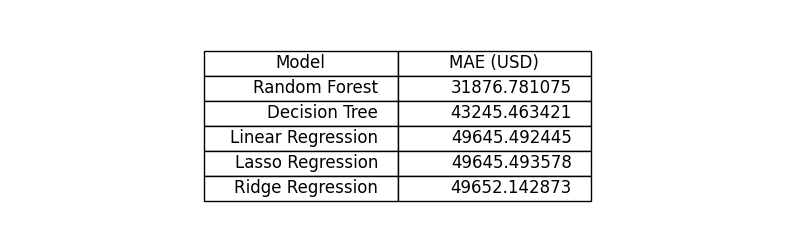

In [6]:
# Create a PNG image of the results table using matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Recreate the results dataframe (replace with your actual results if needed)
data = {
    "Model": [
        "Random Forest",
        "Decision Tree",
        "Linear Regression",
        "Lasso Regression",
        "Ridge Regression"
    ],
    "MAE (USD)": [
        31876.781075,
        43245.463421,
        49645.492445,
        49645.493578,
        49652.142873
    ]
} # ofc this could be automated, but I was just lazy and let gpt to do this part for me.

results_df = pd.DataFrame(data)

# Create figure
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')

# Create table
table = ax.table(
    cellText=results_df.values,
    colLabels=results_df.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(0.5, 1.5)

# Save as PNG
file_path = "table.png"
plt.savefig(file_path, bbox_inches='tight', dpi=300, transparent=True)